In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.optimize as opt

## 7.01 Equilibrazione

Uso il codice  Monte Carlo di dinamica molecolare NVT per calcolare alcune proprietà di un sistema in diverse condizioni termodinamiche.

- solid phase: $\rho^\star = 1.1$, $T^\star = 0.8$ (cut-off radius: $r_c = 2.2$)
- liquid phase: $\rho^\star = 0.8$, $T^\star = 1.1$ (cut-off radius: $r_c = 2.5$)
- gas phase: $\rho^\star = 0.05$, $T^\star = 1.2$ (cut-off radius: $r_c = 5.0$)


L'algoritmo propone con una probabilità di transizione uniforme $T(\vec{x}|\vec{y})$ di passo $\Delta$, scelto in modo da rispettare la regola empirica del $50 \%$ nel campionamento di Metropolis della distribuzione di probabilità 
$$
p({\vec{x}})=\frac{e^{-\beta U}}{Z}
$$

In questo modo si ottiene una configurazione di molecole all'equilibrio termodinamico nelle diverse condizioni definite sopra


In una prima fase eseguo $n_{step}=800$ salvando i valori istantanei di energia e pressione per controllare che il sistema termalizzi 

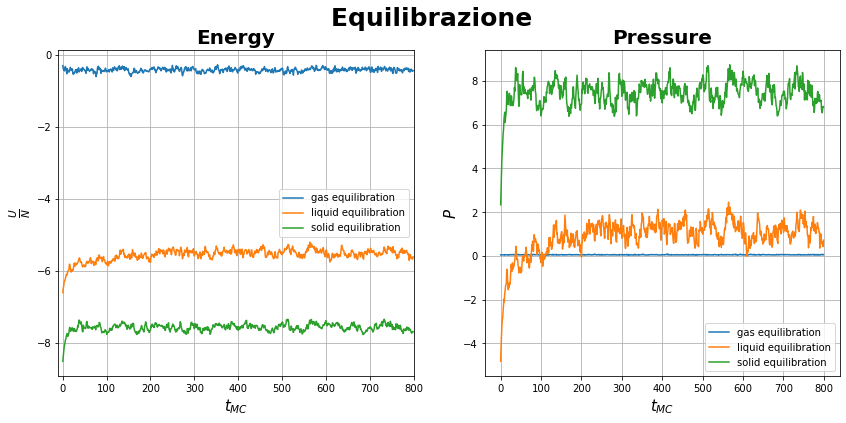

In [320]:
cartelle=['gas', 'liquid', 'solid']


E_eq_gas=np.array([])
E_eq_liquid=np.array([])
E_eq_solid=np.array([])
Es_eq=[E_eq_gas, E_eq_liquid, E_eq_solid]

P_eq_gas=np.array([])
P_eq_liquid=np.array([])
P_eq_solid=np.array([])
Ps_eq=[P_eq_gas, P_eq_liquid, P_eq_solid]
for i in range(len(cartelle)):
    file=open(cartelle[i]+'/output.equilib_energy.dat')
    Es_eq[i]=(np.loadtxt(file))
    
    file=open(cartelle[i]+'/output.equilib_press.dat')
    Ps_eq[i]=np.loadtxt(file)

    

    
assert len(Es_eq[0])==len(Ps_eq[0])
M=len(Es_eq[0])
t_gas=np.linspace(0,M-1,M)

assert len(Es_eq[1])==len(Ps_eq[1])
M=len(Es_eq[1])
t_liquid=np.linspace(0,M-1,M)

assert len(Es_eq[2])==len(Ps_eq[2])
M=len(Es_eq[2])
t_solid=np.linspace(0,M-1,M)


fig,ax=plt.subplots(1,2,figsize=(14,6))
plt.suptitle('Equilibrazione ', fontsize=25, fontweight='bold')

ax[0].plot(t_gas,Es_eq[0],label='gas equilibration')
ax[0].plot(t_liquid,Es_eq[1],label='liquid equilibration')
ax[0].plot(t_solid,Es_eq[2],label='solid equilibration')
ax[0].legend()
ax[0].set_xlabel(r'$t_{MC}$', fontsize=15)
ax[0].set_ylabel(r'$\frac{U}{N}$', fontsize=15)
ax[0].set_title('Energy', fontsize=20, fontweight='bold')
ax[0].set_xlim(-10,800)
ax[0].grid(True)

ax[1].plot(t_gas,Ps_eq[0],label='gas equilibration')
ax[1].plot(t_liquid,Ps_eq[1],label='liquid equilibration')
ax[1].plot(t_solid,Ps_eq[2],label='solid equilibration')
ax[1].legend()
ax[1].set_xlabel(r'$t_{MC}$', fontsize=15)
ax[1].set_ylabel(r'$P$', fontsize=15)
ax[1].set_title('Pressure', fontsize=20, fontweight='bold')
ax[1].grid(True)


Si osserva come in tutti i casi il sistema raggiunge l'equilibrio termodinamico. 

## Autocorrelazione

In una seconda fase eseguo $M=5x10^5$ passi partendo dalla configurazione equilibrata, salvando anche in questo caso i dati istantanei di energia e pressione. Uso poi questi dati per calcolare la funzione di autocorrelazione che, per processi casuali stazionari, non è altro che la covarianza del processo con una copia di se stesso traslata nel tempo.
$$
Ac_{[x]}(\tau)=\frac{<x(t)x(t-\tau)>-<x(t)x(t+\tau)>}{\sigma_x^2}
$$

Questa funzione ci permette di capire dopo quanti passi montecarlo il processo non è più correlato e di conseguenze ci permette di definire la grandezza dei blocchi in modo da garantire che i dati nei blocchi siano effettivamente indipendenti tra loro.

Oltre a calcolare la funzione di autocorrelazione provo a interpolarla con una tipica funzione di decadimento esponenziale della forma

$$
f(t)=e^{-\frac{t}{t_c}}
$$


In [382]:
P_gas=np.array([])
P_liquid=np.array([])
P_solid=np.array([])
Ps=[P_gas, P_liquid, P_solid]

E_gas=np.array([])
E_liquid=np.array([])
E_solid=np.array([])
Es=[E_gas, E_liquid, E_solid]

for i in range(len(cartelle)):
    file=open(cartelle[i]+'/output.energia_istant.dat')
    Es[i]=(np.loadtxt(file))
    
    file=open(cartelle[i]+'/output.virial_istant.dat')
    Ps[i]=np.loadtxt(file)

    
def autocorrelation(x):
    M=len(x)
    t=np.linspace(0,M-1,M)

    t_max=len(t)
    X=np.zeros(t_max)
    mean=np.mean(x)
    var=np.var(x)

    for i in range(t_max):
        X[i]=1/(t_max-i)*np.sum(x[0:t_max-i]*x[i:t_max])-1/(t_max-i)**2*np.sum(x[0:t_max-i])*np.sum(x[i:t_max])

    X=X/var
    return X

def func(t,t_c):
    return np.exp(-t/t_c)

def XE_XP_plot(X_E, X_P, cartella):
    
    assert len(X_E)==len(X_P)
    M=len(X_E)
    t=np.linspace(0,M-1,M)

    popt_E, pcov_E = opt.curve_fit(func, t, X_E)
    popt_P, pcov_P = opt.curve_fit(func, t, X_P)

    assert len(X_E)==len(X_P)
    M=len(X_E)
    t=np.linspace(0,M-1,M)

    X_E_appo=X_E[0:500]
    t_appo=t[0:500]

    X_P_appo=X_P[0:500]

    fig,ax=plt.subplots(2,1,figsize=(14,12))
    plt.suptitle(cartella+ ' Autocorrelation', fontsize=25, fontweight='bold')
    ax[0].plot(t_appo,X_E_appo,'.', ls='--',label='autocorrelation funtion')
    ax[0].plot(t_appo,func(t_E_appo,popt_E),alpha=0.7,label='exponential decay')
    ax[0].legend()
    ax[0].set_xlabel(r'$t_{MC}$',fontsize=12)
    ax[0].set_ylabel(r'$\chi(t_{MC})$',fontsize=12)
    ax[0].set_title('Energy Autocorrelation', fontweight='bold', fontsize=15)
    ax[0].set_xlim(0,300)
    ax[0].grid(True)

    ax[1].plot(t_appo,X_P_appo,'.', ls='--',label='autocorrelation funtion')
    ax[1].plot(t_appo,func(t_P_appo,popt_P),alpha=0.7,label='exponential decay')
    ax[1].set_xlabel(r'$t_{MC}$',fontsize=12)
    ax[1].set_ylabel(r'$\chi(t_{MC})$',fontsize=12)
    ax[1].set_title('Pressure Autocorrelation', fontweight='bold', fontsize=15)
    ax[1].grid(True)
    ax[1].set_xlim(0,300)
    ax[1].legend()
    plt.show()

In [326]:
print('autocorrelation E gas')
X_E_gas=autocorrelation(Es[0])
print('autocorrelation E liquid')
X_E_liquid=autocorrelation(Es[1])
print('autocorrelation E solid')
X_E_solid=autocorrelation(Es[2])

autocorrelation E gas
autocorrelation E liquid
autocorrelation E solid


In [327]:
print('autocorrelation P gas')
X_P_gas=autocorrelation(Ps[0])
print('autocorrelation P liquid')
X_P_liquid=autocorrelation(Ps[1])
print('autocorrelation P solid')
X_P_solid=autocorrelation(Ps[2])

autocorrelation P gas
autocorrelation P liquid
autocorrelation P solid


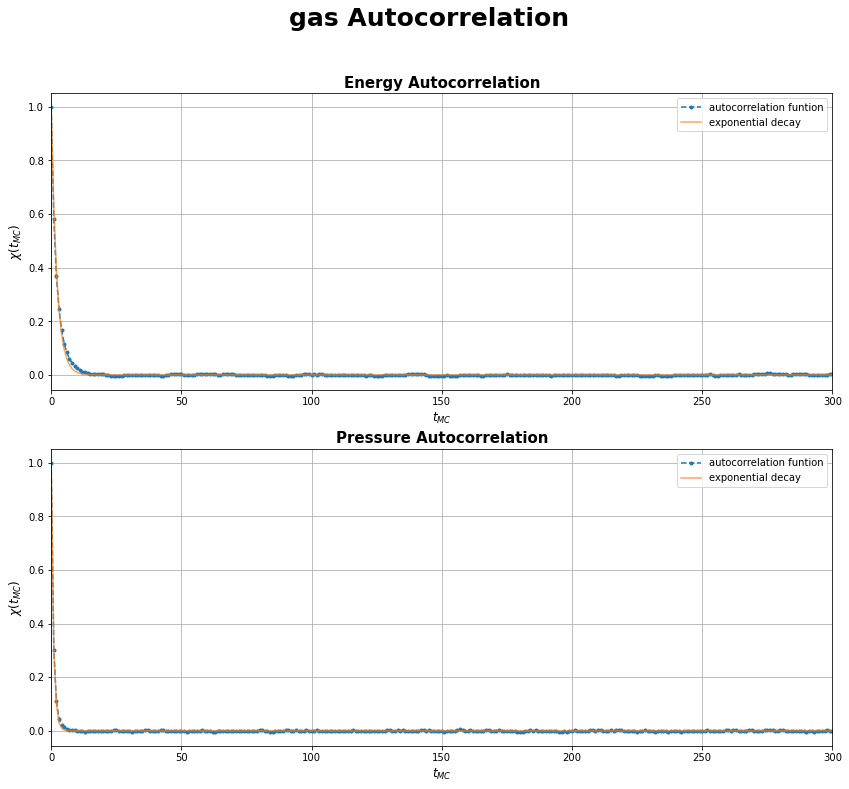

In [383]:
XE_XP_plot(X_E_gas, X_P_gas, cartelle[0])

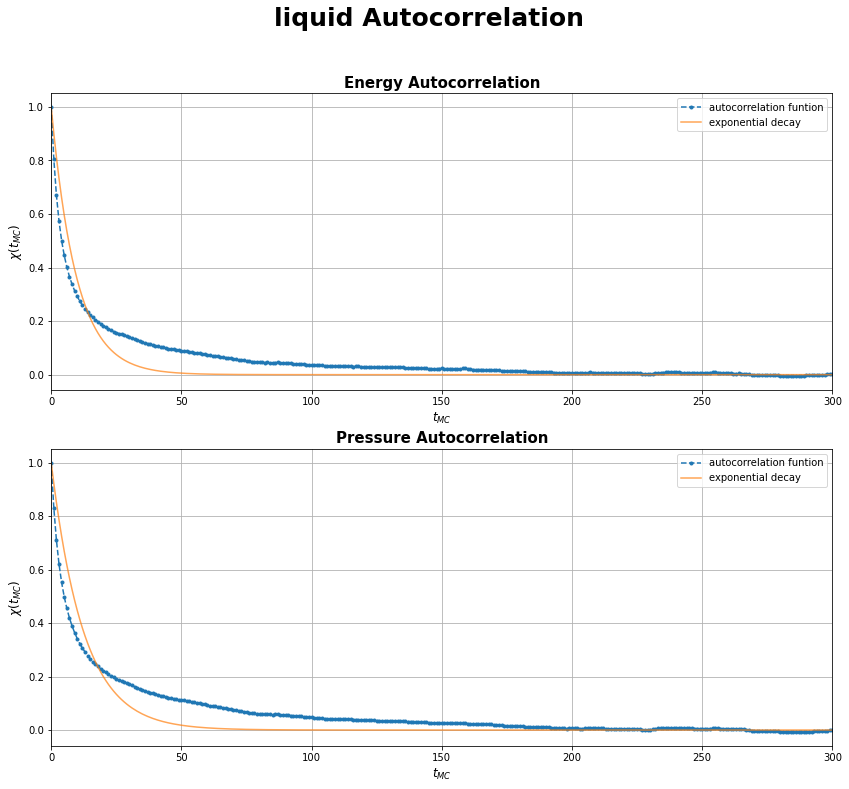

In [384]:
XE_XP_plot(X_E_liquid, X_P_liquid, cartelle[1])

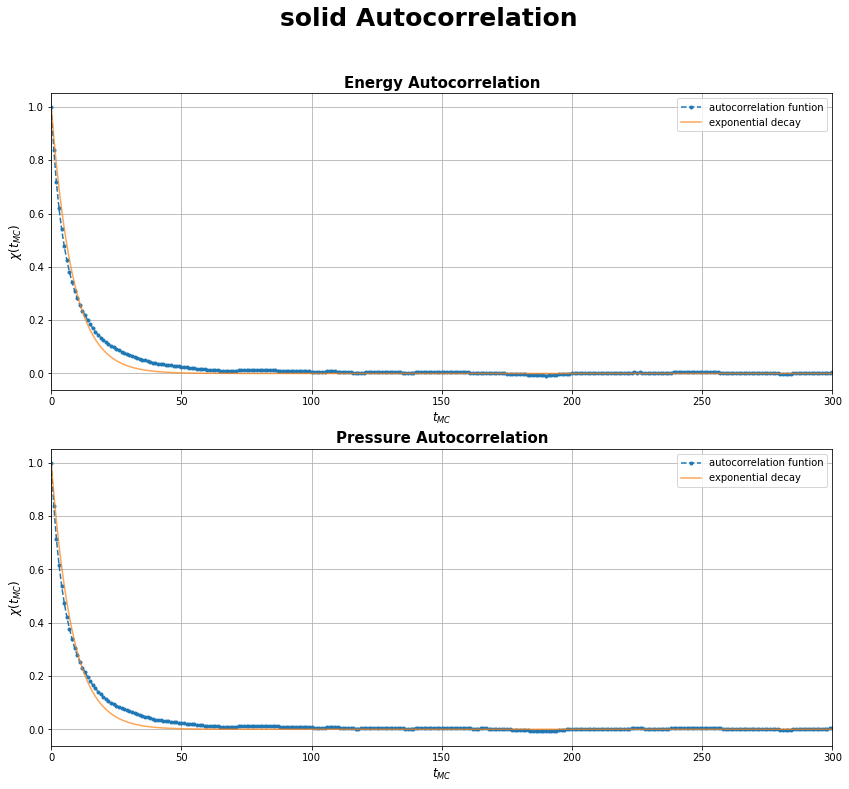

In [385]:
XE_XP_plot(X_E_solid, X_P_solid, cartelle[2])

Si osserva come come nel caso del gas l'autocorrelazione si annulla più velocemente: dopo circa $n_{step}^{MC}=25$, mentre nel caso di liquido e solido il numero di passi è dell'ordine delle centinaia.

## Block Error in funzione del numero di passi per blocco

In [336]:
Ls=np.geomspace(10,500,60, dtype=int)

def Block_error(x, L):   #takes in the quantity and the number of steps per block
    assert type(L==int)
    M=len(x)
    N_block=int(M/L)

    ave=np.zeros(N_block)
    ave2=np.zeros(N_block)

    for j in range(N_block):
        ave[j]=np.sum(x[j*L:(j+1)*L])/L

    ave2=ave**2
    average=np.sum(ave)/N_block
    average2=np.sum(ave2)/N_block

    final_error= np.sqrt((average2-average**2)/N_block)
    return final_error

def Final_errors(x, Ls):
    
    final_errors=np.zeros(len(Ls))
    for i in range(len(Ls)):
        final_errors[i]=Block_error(x,Ls[i])
    return final_errors

In [337]:
final_errors_E_g=Final_errors(Es[0],Ls)

In [338]:
final_errors_P_g=Final_errors(Ps[0],Ls)

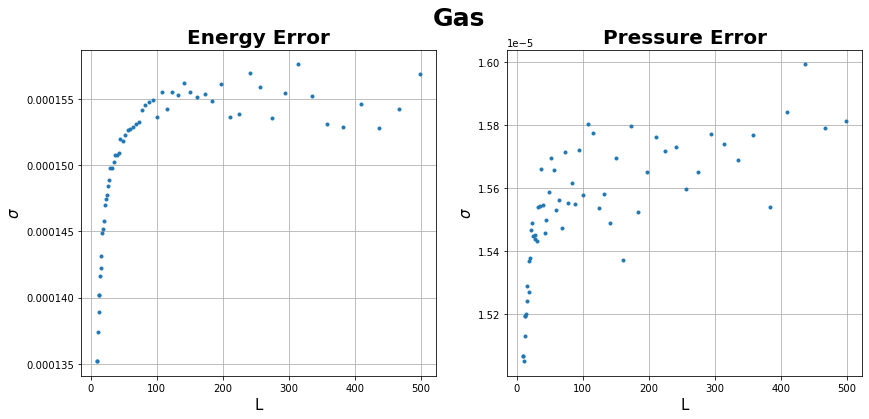

In [339]:
fig, ax=plt.subplots(1,2,figsize=(14,6))
plt.suptitle('Gas', fontsize=25, fontweight='bold')
ax[0].plot(Ls,final_errors_E_g, '.')
ax[0].set_title('Energy Error', fontsize=20, fontweight='bold')
ax[0].set_xlabel('L', fontsize=15)
ax[0].set_ylabel(r'$\sigma$', fontsize=15)
ax[0].grid(True)
ax[1].plot(Ls,final_errors_P_g, '.')
ax[1].set_title('Pressure Error', fontsize=20, fontweight='bold')
ax[1].set_xlabel('L', fontsize=15)
ax[1].set_ylabel(r'$\sigma$', fontsize=15)
ax[1].grid(True)

plt.show()
#plt.xscale('log')
#plt.xlim(0,500)

In [340]:
final_errors_E_l=Final_errors(Es[1],Ls)

In [341]:
final_errors_P_l=Final_errors(Ps[1],Ls)

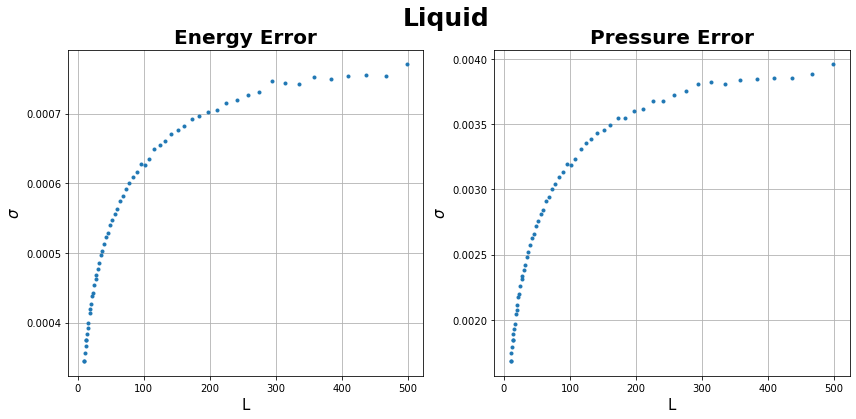

In [342]:
fig, ax=plt.subplots(1,2,figsize=(14,6))
plt.suptitle('Liquid', fontsize=25, fontweight='bold')
ax[0].plot(Ls,final_errors_E_l, '.')
ax[0].set_title('Energy Error', fontsize=20, fontweight='bold')
ax[0].set_xlabel('L', fontsize=15)
ax[0].set_ylabel(r'$\sigma$', fontsize=15)
ax[0].grid(True)
ax[1].plot(Ls,final_errors_P_l, '.')
ax[1].set_title('Pressure Error', fontsize=20, fontweight='bold')
ax[1].set_xlabel('L', fontsize=15)
ax[1].set_ylabel(r'$\sigma$', fontsize=15)
ax[1].grid(True)

plt.show()
#plt.xscale('log')
#plt.xlim(0,500)

In [343]:
final_errors_E_s=Final_errors(Es[2],Ls)

In [344]:
final_errors_P_s=Final_errors(Ps[2],Ls)

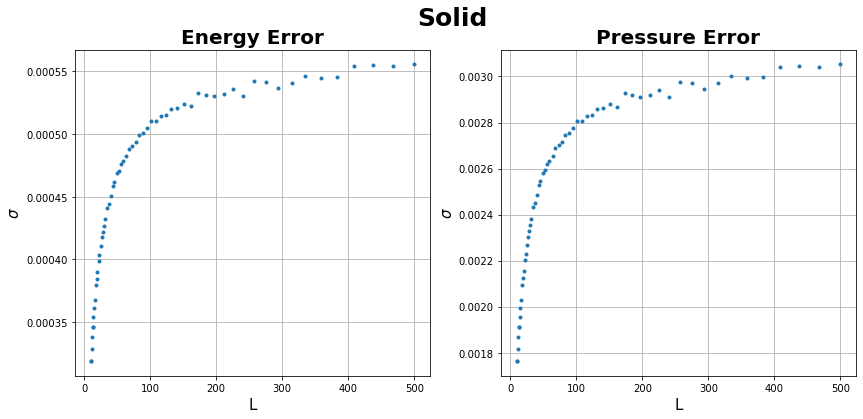

In [345]:
fig, ax=plt.subplots(1,2,figsize=(14,6))
plt.suptitle('Solid', fontsize=25, fontweight='bold')
ax[0].plot(Ls,final_errors_E_s, '.')
ax[0].set_title('Energy Error', fontsize=20, fontweight='bold')
ax[0].set_xlabel('L', fontsize=15)
ax[0].set_ylabel(r'$\sigma$', fontsize=15)
ax[0].grid(True)
ax[1].plot(Ls,final_errors_P_s, '.')
ax[1].set_title('Pressure Error', fontsize=20, fontweight='bold')
ax[1].set_xlabel('L', fontsize=15)
ax[1].set_ylabel(r'$\sigma$', fontsize=15)
ax[1].grid(True)

plt.show()
#plt.xscale('log')
#plt.xlim(0,500)

L'errore aumenta in una prima fase (quando ancora i dati sono autocorrelati), mentre dal momento in cui il numero di step per blocco raggiunge il valore tale da rendere indipendenti i valori al suo interno, l'errore smette di crescere e oscilla intorno al valore vero dato dall'algoritmo di Metropolis

## 7.02  Stima di $g(r)$ con algoritmo di MC NVT



In [346]:
r_gas=np.array([])
g_gas=np.array([])
err_gas=np.array([])

r_liquid=np.array([])
g_liquid=np.array([])
err_liquid=np.array([])

r_solid=np.array([])
g_solid=np.array([])
err_solid=np.array([])

rs=[r_gas, r_liquid, r_solid]
gs=[g_gas, g_liquid, g_solid]
errors=[err_gas, err_liquid, err_solid]

for i in range(len(cartelle)):
    file=(cartelle[i]+"/output.gave.0")
    rs[i],gs[i],errors[i]=np.loadtxt(file, usecols=[0,1,2], delimiter=',', unpack=True)

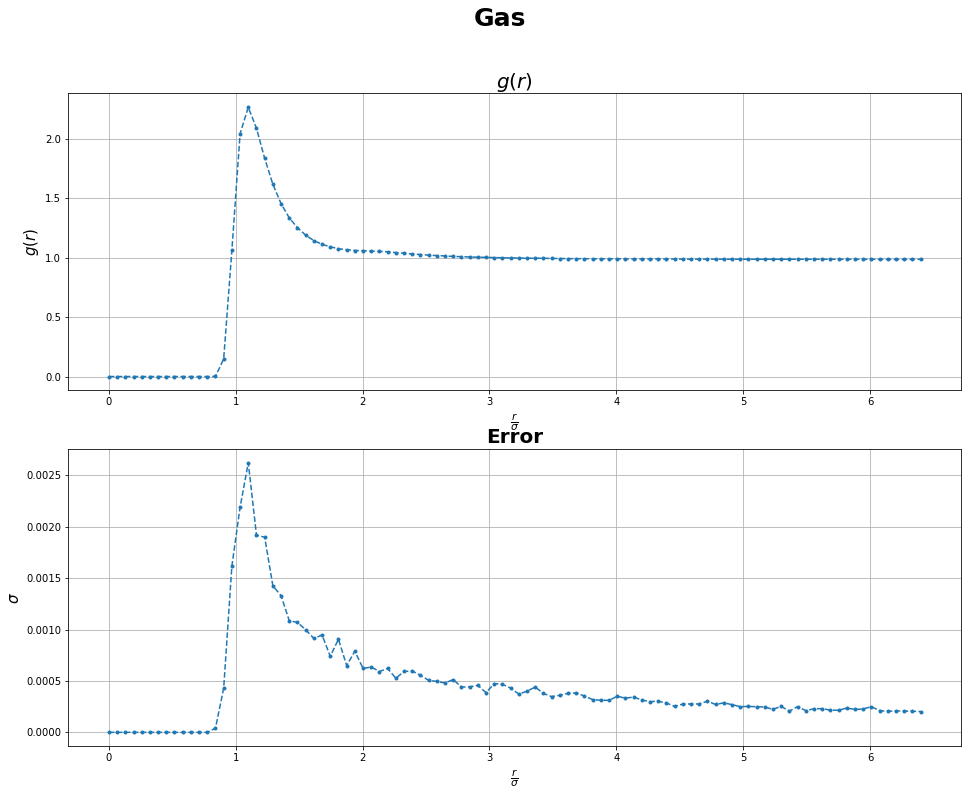

In [347]:
fig,ax=plt.subplots(2,1,figsize=(16,12))
plt.suptitle('Gas', fontsize=25, fontweight='bold')
ax[0].errorbar(rs[0],gs[0],yerr=errors[0], fmt='.--')
ax[0].grid(True)
ax[0].set_title('$g(r)$', fontsize=20, fontweight='bold')
ax[0].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[0].set_ylabel(r'$g(r)$', fontsize=15)

ax[1].plot(rs[0],errors[0],'.--')
ax[1].grid(True)
ax[1].set_title('Error', fontsize=20, fontweight='bold')
ax[1].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[1].set_ylabel(r'$\sigma$', fontsize=15)
plt.show()

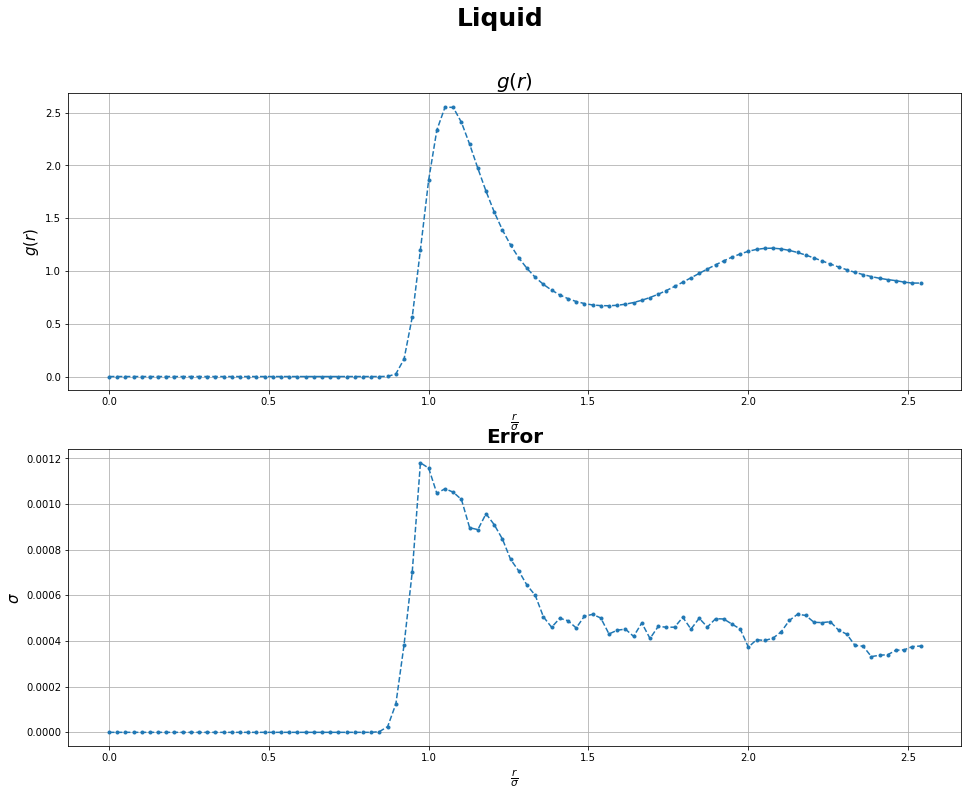

In [348]:
fig,ax=plt.subplots(2,1,figsize=(16,12))
plt.suptitle('Liquid', fontsize=25, fontweight='bold')
ax[0].errorbar(rs[1],gs[1],yerr=errors[1], fmt='.--')
ax[0].grid(True)
ax[0].set_title('$g(r)$', fontsize=20, fontweight='bold')
ax[0].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[0].set_ylabel(r'$g(r)$', fontsize=15)

ax[1].plot(rs[1],errors[1],'.--')
ax[1].set_title('Error', fontsize=20, fontweight='bold')
ax[1].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[1].set_ylabel(r'$\sigma$', fontsize=15)
ax[1].grid(True)
plt.show()

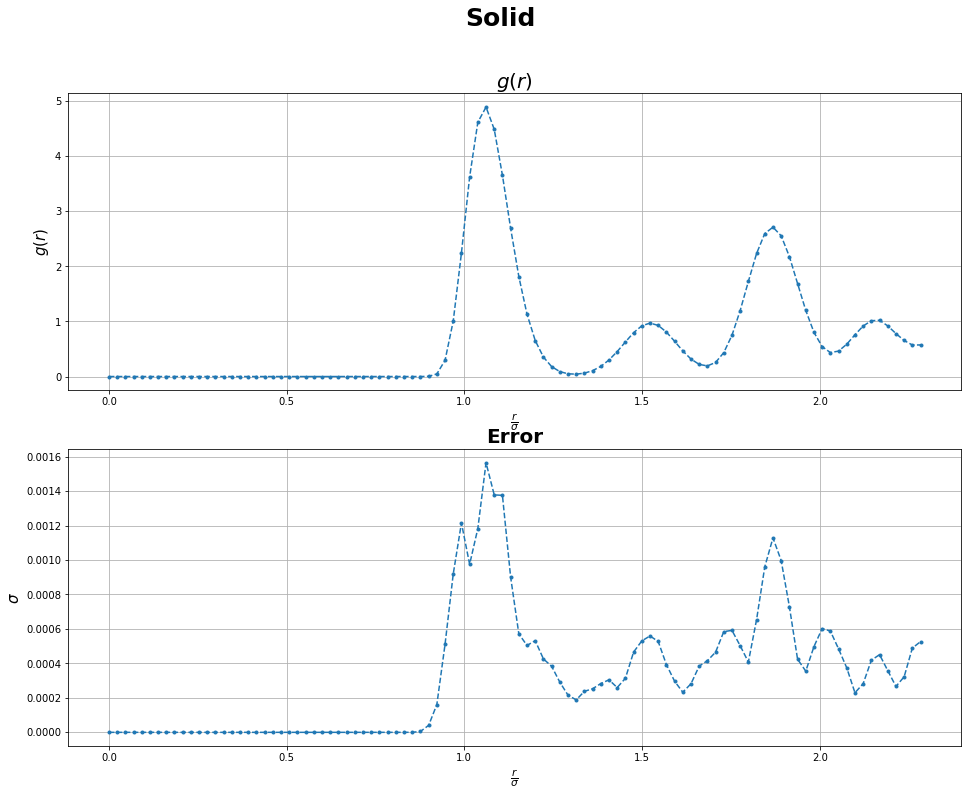

In [349]:
fig,ax=plt.subplots(2,1,figsize=(16,12))
plt.suptitle('Solid', fontsize=25, fontweight='bold')

ax[0].errorbar(rs[2],gs[2],yerr=errors[2], fmt='.--')
ax[0].grid(True)
ax[0].set_title('$g(r)$', fontsize=20, fontweight='bold')
ax[0].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[0].set_ylabel(r'$g(r)$', fontsize=15)

ax[1].plot(rs[2],errors[2],'.--')
ax[1].grid(True)
ax[1].set_title('Error', fontsize=20, fontweight='bold')
ax[1].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[1].set_ylabel(r'$\sigma$', fontsize=15)
plt.show()

# 7.03 & 7.04

### Energia e Pressione

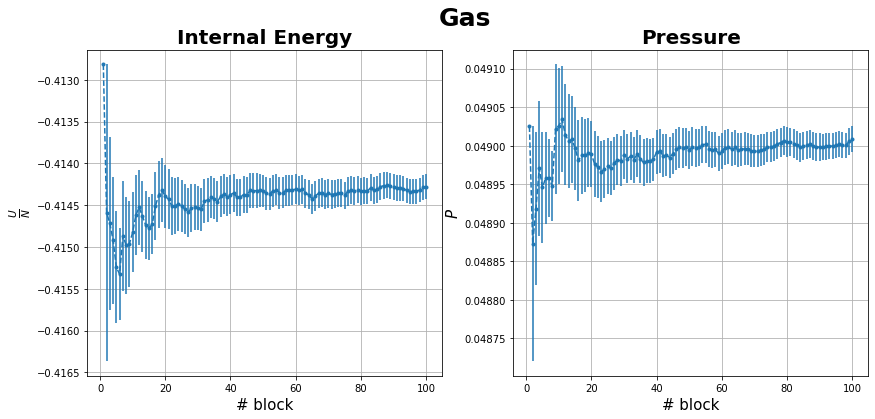

In [350]:
file=(cartelle[0]+"/output.epot.0")
n_block, U, err_U=np.loadtxt(file, usecols=[0,1,2], delimiter=',', unpack=True)

file=(cartelle[0]+"/output.pres.0")
n_block, P, err_P=np.loadtxt(file, usecols=[0,1,2], delimiter=',', unpack=True)

fig,ax=plt.subplots(1,2,figsize=(14,6))
plt.suptitle('Gas', fontsize=25, fontweight='bold')
ax[0].errorbar(n_block,U,yerr=err_U, fmt='.--')
ax[0].grid(True)
ax[0].set_title('Internal Energy', fontsize=20, fontweight='bold')
ax[0].set_ylabel(r'$\frac{U}{N}$', fontsize=15)
ax[0].set_xlabel('# block', fontsize=15)

ax[1].errorbar(n_block,P,yerr=err_P, fmt='.--')
ax[1].set_title('Pressure', fontsize=20, fontweight='bold')
ax[1].set_ylabel(r'$P$', fontsize=15)
ax[1].set_xlabel('# block', fontsize=15)
ax[1].grid(True)
plt.show()

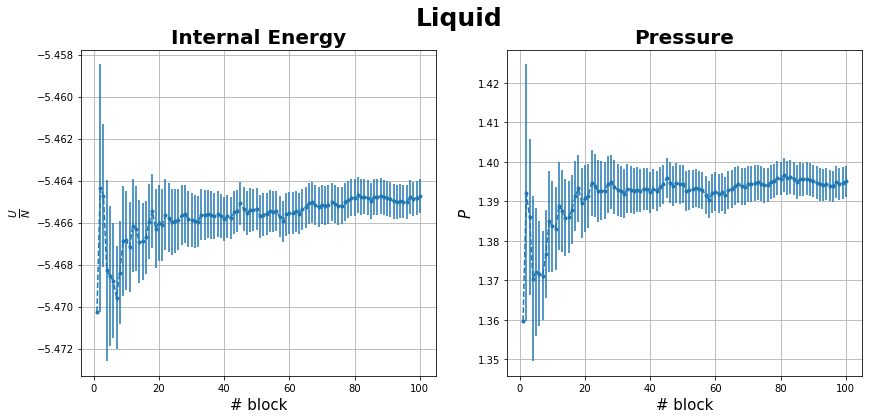

In [351]:
file=(cartelle[1]+"/output.epot.0")
n_block, U, err_U=np.loadtxt(file, usecols=[0,1,2], delimiter=',', unpack=True)

file=(cartelle[1]+"/output.pres.0")
n_block, P, err_P=np.loadtxt(file, usecols=[0,1,2], delimiter=',', unpack=True)

fig,ax=plt.subplots(1,2,figsize=(14,6))
plt.suptitle('Liquid', fontsize=25, fontweight='bold')
ax[0].errorbar(n_block,U,yerr=err_U, fmt='.--')
ax[0].grid(True)
ax[0].set_title('Internal Energy', fontsize=20, fontweight='bold')
ax[0].set_ylabel(r'$\frac{U}{N}$', fontsize=15)
ax[0].set_xlabel('# block', fontsize=15)

ax[1].errorbar(n_block,P,yerr=err_P, fmt='.--')
ax[1].set_title('Pressure', fontsize=20, fontweight='bold')
ax[1].set_ylabel(r'$P$', fontsize=15)
ax[1].set_xlabel('# block', fontsize=15)
ax[1].grid(True)
plt.show()

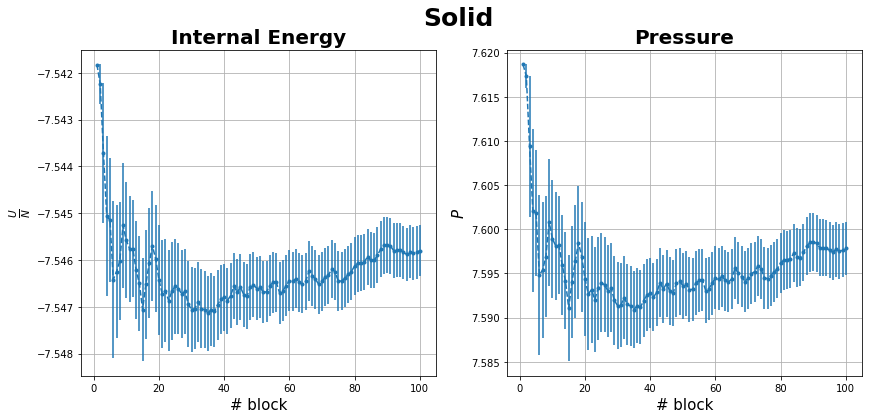

In [352]:
file=(cartelle[2]+"/output.epot.0")
n_block, U, err_U=np.loadtxt(file, usecols=[0,1,2], delimiter=',', unpack=True)

file=(cartelle[2]+"/output.pres.0")
n_block, P, err_P=np.loadtxt(file, usecols=[0,1,2], delimiter=',', unpack=True)

fig,ax=plt.subplots(1,2,figsize=(14,6))
plt.suptitle('Solid', fontsize=25, fontweight='bold')
ax[0].errorbar(n_block,U,yerr=err_U, fmt='.--')
ax[0].grid(True)
ax[0].set_title('Internal Energy', fontsize=20, fontweight='bold')
ax[0].set_ylabel(r'$\frac{U}{N}$', fontsize=15)
ax[0].set_xlabel('# block', fontsize=15)

ax[1].errorbar(n_block,P,yerr=err_P, fmt='.--')
ax[1].set_title('Pressure', fontsize=20, fontweight='bold')
ax[1].set_ylabel(r'$P$', fontsize=15)
ax[1].set_xlabel('# block', fontsize=15)
ax[1].grid(True)
plt.show()

## Confronto $g(r)$ tra algoritmo di Verlet e Algoritmo Monte carlo NVT

In [377]:
r_gas=np.array([])
g_gas=np.array([])
err_gas=np.array([])

r_liquid=np.array([])
g_liquid=np.array([])
err_liquid=np.array([])

r_solid=np.array([])
g_solid=np.array([])
err_solid=np.array([])

rs_Verlet=[r_gas, r_liquid, r_solid]
gs_Verlet=[g_gas, g_liquid, g_solid]
errors_Verlet=[err_gas, err_liquid, err_solid]

for i in range(len(cartelle)):
    file=('Mol_dynamics/'+cartelle[i]+"/output.gave.0")
    rs_Verlet[i],gs_Verlet[i],errors_Verlet[i]=np.loadtxt(file, usecols=[0,1,2], delimiter=',', unpack=True)

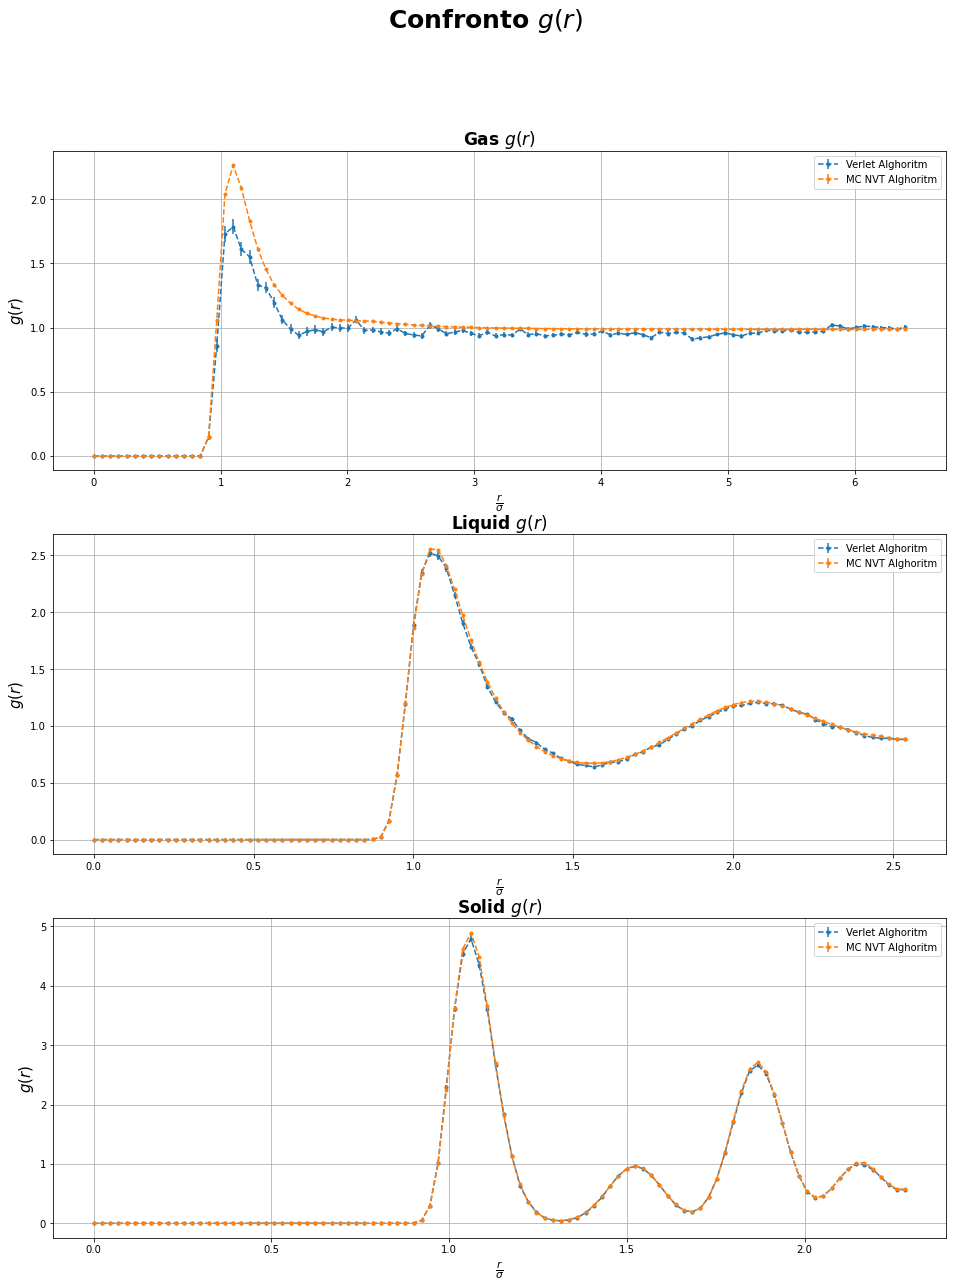

In [370]:
fig,ax=plt.subplots(3,1,figsize=(16,20))
plt.suptitle('Confronto $g(r)$', fontsize=25, fontweight='bold')

ax[0].errorbar(rs_Verlet[0],gs_Verlet[0],yerr=errors_Verlet[0], fmt='.--', label='Verlet Alghoritm')
ax[0].errorbar(rs[0],gs[0],yerr=errors[0], fmt='.--', label='MC NVT Alghoritm')
ax[0].grid(True)
ax[0].set_title('Gas $g(r)$', fontsize=17, fontweight='bold')
ax[0].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[0].set_ylabel(r'$g(r)$', fontsize=15)
ax[0].legend()

ax[1].errorbar(rs_Verlet[1],gs_Verlet[1],yerr=errors_Verlet[1], fmt='.--', label='Verlet Alghoritm')
ax[1].errorbar(rs[1],gs[1],yerr=errors[1], fmt='.--', label='MC NVT Alghoritm')
ax[1].grid(True)
ax[1].set_title('Liquid $g(r)$', fontsize=17, fontweight='bold')
ax[1].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[1].set_ylabel(r'$g(r)$', fontsize=15)
ax[1].legend()

ax[2].errorbar(rs_Verlet[2],gs_Verlet[2],yerr=errors_Verlet[2], fmt='.--', label='Verlet Alghoritm')
ax[2].errorbar(rs[2],gs[2],yerr=errors[2], fmt='.--', label='MC NVT Alghoritm')
ax[2].grid(True)
ax[2].set_title('Solid $g(r)$', fontsize=17, fontweight='bold')
ax[2].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[2].set_ylabel(r'$g(r)$', fontsize=15)
ax[2].legend()
plt.show()

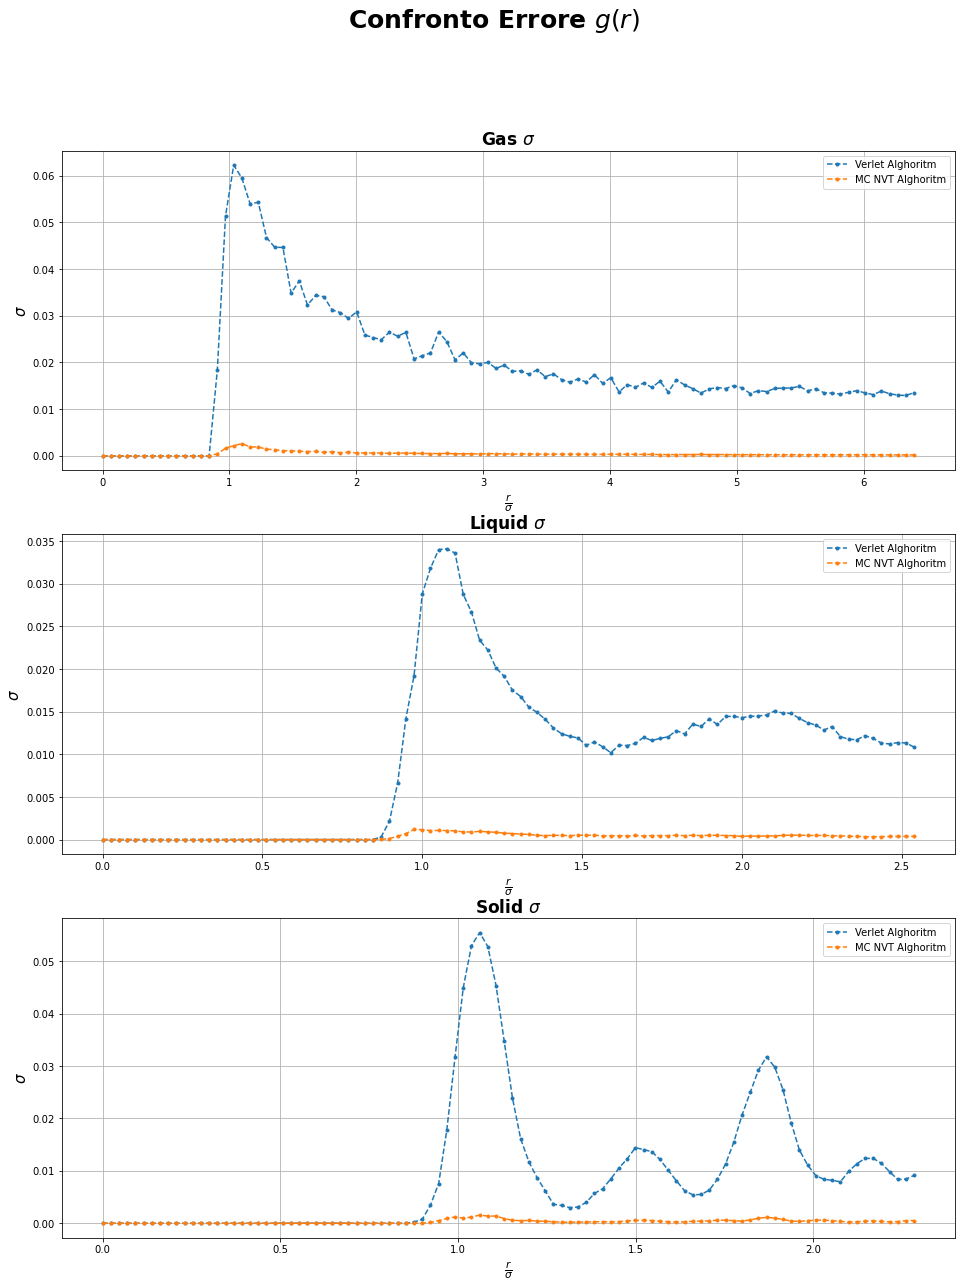

In [376]:
fig,ax=plt.subplots(3,1,figsize=(16,20))
plt.suptitle('Confronto Errore $g(r)$', fontsize=25, fontweight='bold')

ax[0].plot(rs_Verlet[0],errors_Verlet[0], '.',ls='--', label='Verlet Alghoritm')
ax[0].plot(rs[0],errors[0], '.',ls='--', label='MC NVT Alghoritm')
ax[0].grid(True)
ax[0].set_title('Gas $\sigma$', fontsize=17, fontweight='bold')
ax[0].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[0].set_ylabel(r'$\sigma$', fontsize=15)
ax[0].legend()

ax[1].plot(rs_Verlet[1],errors_Verlet[1],'.', ls='--', label='Verlet Alghoritm')
ax[1].plot(rs[1],errors[1], '.',ls='--', label='MC NVT Alghoritm')
ax[1].grid(True)
ax[1].set_title('Liquid $\sigma$', fontsize=17, fontweight='bold')
ax[1].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[1].set_ylabel(r'$\sigma$', fontsize=15)
ax[1].legend()

ax[2].plot(rs_Verlet[2],errors_Verlet[2],'.', ls='--', label='Verlet Alghoritm')
ax[2].plot(rs[2],errors[2],'.', ls='--', label='MC NVT Alghoritm')
ax[2].grid(True)
ax[2].set_title('Solid $\sigma$', fontsize=17, fontweight='bold')
ax[2].set_xlabel(r'$\frac{r}{\sigma}$', fontsize=15)
ax[2].set_ylabel(r'$\sigma$', fontsize=15)
ax[2].legend()
plt.show()

Si osserva come entrambi gli algoritmi riescano a calcolare bene la funzione di distribuzione radiale $g(r)$. L'algoritmo Monte Carlo però risulta avere incertezze molto più basse e sembra avere, in modo particolare per il gas, un andamento più liscio rispetto all'algoritmo di Verlet, il quale fà più fatica, specialmente nel caso del gas, probabilmente a causa delle maggiori fluttuazioni statistiche